# Enhanced CDR Prediction Analysis

This notebook implements rigorous methodology for CDR prediction:
1. **Age-only baselines** for both binary and multiclass models
2. **CV-selected hyperparameters** (no hardcoding)
3. **Calibration curves** for clinical deployment readiness
4. **Brain volume ratios** to prove structural features add value

## 1. Data Loading and Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, cohen_kappa_score
)
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
# Load and merge data
df = pd.read_csv('oasis_cross-sectional.csv')
df = df[~df['ID'].str.contains('_MR2', na=False)]  # Baseline scans only
df = df.drop(columns=['Educ', 'SES', 'MMSE', 'eTIV', 'Delay', 'Hand'])

mri_df = pd.read_csv('oasis_roi_volumes.tsv', sep='\t')
df = df.merge(mri_df, left_on='ID', right_on='subject_id', how='inner')
df = df.drop(columns=['subject_id'])

# Get ROI columns
roi_columns = [col for col in df.columns if 'lh_' in col or 'rh_' in col]

# Scale ROI volumes by ASF
for col in roi_columns:
    df[col] = df[col] * df['ASF']

print(f"Dataset shape: {df.shape}")
print(f"\nCDR distribution:")
print(df['CDR'].value_counts().sort_index())

Dataset shape: (405, 16)

CDR distribution:
CDR
0.0    312
0.5     68
1.0     23
2.0      2
Name: count, dtype: int64


In [3]:
# Feature engineering: Create brain volume ratios
# These ratios may capture structural changes better than absolute volumes

# Hippocampal asymmetry (left/right ratio)
df['hippocampus_asymmetry'] = df['lh_hippocampus'] / (df['rh_hippocampus'] + 1e-6)

# Entorhinal asymmetry
df['entorhinal_asymmetry'] = df['lh_entorhinal'] / (df['rh_entorhinal'] + 1e-6)

# Total hippocampal volume
df['total_hippocampus'] = df['lh_hippocampus'] + df['rh_hippocampus']

# Total entorhinal volume
df['total_entorhinal'] = df['lh_entorhinal'] + df['rh_entorhinal']

# Hippocampus to whole brain ratio (normalized)
df['hippocampus_to_brain_ratio'] = df['total_hippocampus'] / (df['nWBV'] * 1e6)

# Ventricular expansion (larger ventricles = more atrophy)
df['total_ventricles'] = df['lh_lateral_ventricle'] + df['rh_lateral_ventricle']
df['ventricle_to_brain_ratio'] = df['total_ventricles'] / (df['nWBV'] * 1e6)

print(f"\nAdded ratio features:")
ratio_features = [
    'hippocampus_asymmetry', 'entorhinal_asymmetry',
    'total_hippocampus', 'total_entorhinal',
    'hippocampus_to_brain_ratio', 'total_ventricles',
    'ventricle_to_brain_ratio'
]
print(ratio_features)


Added ratio features:
['hippocampus_asymmetry', 'entorhinal_asymmetry', 'total_hippocampus', 'total_entorhinal', 'hippocampus_to_brain_ratio', 'total_ventricles', 'ventricle_to_brain_ratio']


In [4]:
# Create target variables
df['CDR_binary'] = (df['CDR'] > 0).astype(int)

# Fix multiclass: Convert to integer labels
df['CDR_multiclass'] = df['CDR'].copy()
df.loc[df['CDR'] >= 1, 'CDR_multiclass'] = 1.0  # Collapse CDR ≥1
# Convert to integer categorical
cdr_map = {0.0: 0, 0.5: 1, 1.0: 2}
df['CDR_multiclass'] = df['CDR_multiclass'].map(cdr_map)

print(f"Binary CDR distribution:")
print(df['CDR_binary'].value_counts())
print(f"\nMulticlass CDR distribution:")
print(df['CDR_multiclass'].value_counts().sort_index())

Binary CDR distribution:
CDR_binary
0    312
1     93
Name: count, dtype: int64

Multiclass CDR distribution:
CDR_multiclass
0    312
1     68
2     25
Name: count, dtype: int64


## 2. Binary Classification: CDR=0 vs CDR>0

In [5]:
# Prepare features for binary classification
X_binary = df.drop(columns=['ID', 'CDR', 'CDR_binary', 'CDR_multiclass'])
X_binary['M/F'] = (X_binary['M/F'] == 'M').astype(int)
y_binary = df['CDR_binary']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Test set CDR=0: {sum(y_test==0)}, CDR>0: {sum(y_test==1)}")

Training set: 324 samples
Test set: 81 samples
Test set CDR=0: 62, CDR>0: 19


In [6]:
def nested_cv_svm(X_train, y_train, X_test, y_test, model_name, param_grid, task='binary'):
    """
    Perform nested cross-validation with proper hyperparameter selection.
    Returns: best_params, cv_scores, test_predictions, trained_model
    """
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scoring = 'roc_auc' if task == 'binary' else 'accuracy'
    
    outer_scores = []
    best_params_list = []
    
    print(f"\n{'='*60}")
    print(f"NESTED CV: {model_name}")
    print(f"{'='*60}")
    
    for fold_idx, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
        X_train_fold = X_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]
        y_val_fold = y_train.iloc[val_idx]
        
        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled = scaler.transform(X_val_fold)
        
        # Inner CV: GridSearch
        grid_search = GridSearchCV(
            SVC(class_weight='balanced', probability=True, random_state=42),
            param_grid=param_grid,
            cv=inner_cv,
            scoring=scoring,
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train_scaled, y_train_fold)
        best_model = grid_search.best_estimator_
        best_params_list.append(grid_search.best_params_)
        
        # Evaluate
        if task == 'binary':
            y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
            score = roc_auc_score(y_val_fold, y_val_proba)
        else:
            y_val_pred = best_model.predict(X_val_scaled)
            score = accuracy_score(y_val_fold, y_val_pred)
        
        outer_scores.append(score)
        print(f"Fold {fold_idx}: {scoring}={score:.3f}, params={grid_search.best_params_}")
    
    # Most common hyperparameters
    final_params = {}
    for param in param_grid.keys():
        values = [p[param] for p in best_params_list]
        final_params[param] = Counter(values).most_common(1)[0][0]
    
    print(f"\nCV {scoring}: {np.mean(outer_scores):.3f} ± {np.std(outer_scores):.3f}")
    print(f"Selected hyperparameters: {final_params}")
    
    # Train final model on full training set
    scaler_final = StandardScaler()
    X_train_scaled = scaler_final.fit_transform(X_train)
    X_test_scaled = scaler_final.transform(X_test)
    
    final_model = SVC(
        **final_params,
        class_weight='balanced',
        probability=True,
        random_state=42
    )
    final_model.fit(X_train_scaled, y_train)
    
    # Test predictions
    y_test_pred = final_model.predict(X_test_scaled)
    y_test_proba = final_model.predict_proba(X_test_scaled)
    
    return final_params, outer_scores, y_test_pred, y_test_proba, final_model, scaler_final

In [7]:
# Full model with brain features + ratios
param_grid_full = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

(
    best_params_full,
    cv_scores_full,
    y_test_pred_full,
    y_test_proba_full,
    model_full,
    scaler_full
) = nested_cv_svm(
    X_train, y_train, X_test, y_test,
    "Full Model (Brain Features + Ratios)",
    param_grid_full,
    task='binary'
)

test_auc_full = roc_auc_score(y_test, y_test_proba_full[:, 1])
print(f"\nTest AUC: {test_auc_full:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_full, target_names=['CDR=0', 'CDR>0']))


NESTED CV: Full Model (Brain Features + Ratios)
Fold 1: roc_auc=0.948, params={'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Fold 2: roc_auc=0.939, params={'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Fold 3: roc_auc=0.953, params={'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Fold 4: roc_auc=0.905, params={'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Fold 5: roc_auc=0.874, params={'C': 100, 'gamma': 'scale', 'kernel': 'linear'}

CV roc_auc: 0.924 ± 0.030
Selected hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Test AUC: 0.907

Classification Report:
              precision    recall  f1-score   support

       CDR=0       0.95      0.87      0.91        62
       CDR>0       0.67      0.84      0.74        19

    accuracy                           0.86        81
   macro avg       0.81      0.86      0.83        81
weighted avg       0.88      0.86      0.87        81



In [8]:
# Age-only baseline
X_train_age = X_train[['Age']]
X_test_age = X_test[['Age']]

param_grid_age = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear']
}

(
    best_params_age,
    cv_scores_age,
    y_test_pred_age,
    y_test_proba_age,
    model_age,
    scaler_age
) = nested_cv_svm(
    X_train_age, y_train, X_test_age, y_test,
    "Age-Only Baseline",
    param_grid_age,
    task='binary'
)

test_auc_age = roc_auc_score(y_test, y_test_proba_age[:, 1])
print(f"\nTest AUC: {test_auc_age:.3f}")


NESTED CV: Age-Only Baseline
Fold 1: roc_auc=0.849, params={'C': 1, 'kernel': 'rbf'}
Fold 2: roc_auc=0.906, params={'C': 0.1, 'kernel': 'rbf'}
Fold 3: roc_auc=0.897, params={'C': 1, 'kernel': 'rbf'}
Fold 4: roc_auc=0.847, params={'C': 0.1, 'kernel': 'rbf'}
Fold 5: roc_auc=0.876, params={'C': 1, 'kernel': 'rbf'}

CV roc_auc: 0.875 ± 0.024
Selected hyperparameters: {'C': 1, 'kernel': 'rbf'}

Test AUC: 0.903


In [9]:
# Comparison
print("\n" + "="*60)
print("BINARY CLASSIFICATION COMPARISON")
print("="*60)
print(f"\nFull Model:")
print(f"  CV AUC:   {np.mean(cv_scores_full):.3f} ± {np.std(cv_scores_full):.3f}")
print(f"  Test AUC: {test_auc_full:.3f}")
print(f"  Params:   {best_params_full}")

print(f"\nAge-Only Baseline:")
print(f"  CV AUC:   {np.mean(cv_scores_age):.3f} ± {np.std(cv_scores_age):.3f}")
print(f"  Test AUC: {test_auc_age:.3f}")
print(f"  Params:   {best_params_age}")

auc_improvement = test_auc_full - test_auc_age
rel_improvement = (auc_improvement / test_auc_age) * 100

print(f"\n📊 Brain features add: {auc_improvement:.3f} AUC points ({rel_improvement:.1f}% improvement)")

if auc_improvement > 0.05:
    print("✅ Brain volume ratios provide meaningful improvement!")
elif auc_improvement > 0.02:
    print("⚠️  Brain features provide modest improvement (2-5% range)")
else:
    print("⚠️  Brain features add minimal value over age alone")


BINARY CLASSIFICATION COMPARISON

Full Model:
  CV AUC:   0.924 ± 0.030
  Test AUC: 0.907
  Params:   {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Age-Only Baseline:
  CV AUC:   0.875 ± 0.024
  Test AUC: 0.903
  Params:   {'C': 1, 'kernel': 'rbf'}

📊 Brain features add: 0.004 AUC points (0.4% improvement)
⚠️  Brain features add minimal value over age alone


### Calibration Analysis (Clinical Deployment Requirement)

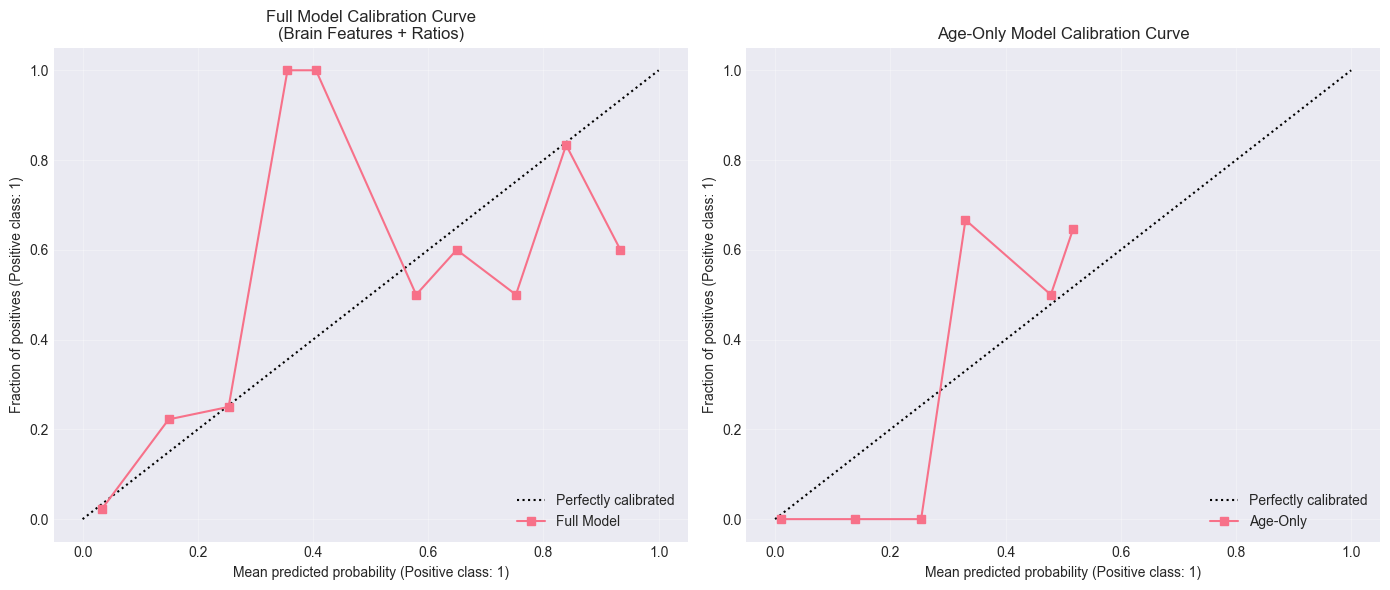


Calibration Interpretation:
- Points near diagonal = well-calibrated predictions
- Above diagonal = underconfident (actual rate > predicted)
- Below diagonal = overconfident (actual rate < predicted)

For clinical deployment, calibration is critical:
- Predicted probabilities should match true risk rates
- Enables informed decision-making for patient care


In [10]:
# Calibration curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full model calibration
CalibrationDisplay.from_predictions(
    y_test, y_test_proba_full[:, 1],
    n_bins=10,
    ax=axes[0],
    name='Full Model'
)
axes[0].set_title('Full Model Calibration Curve\n(Brain Features + Ratios)')
axes[0].grid(alpha=0.3)

# Age-only calibration
CalibrationDisplay.from_predictions(
    y_test, y_test_proba_age[:, 1],
    n_bins=10,
    ax=axes[1],
    name='Age-Only'
)
axes[1].set_title('Age-Only Model Calibration Curve')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCalibration Interpretation:")
print("- Points near diagonal = well-calibrated predictions")
print("- Above diagonal = underconfident (actual rate > predicted)")
print("- Below diagonal = overconfident (actual rate < predicted)")
print("\nFor clinical deployment, calibration is critical:")
print("- Predicted probabilities should match true risk rates")
print("- Enables informed decision-making for patient care")

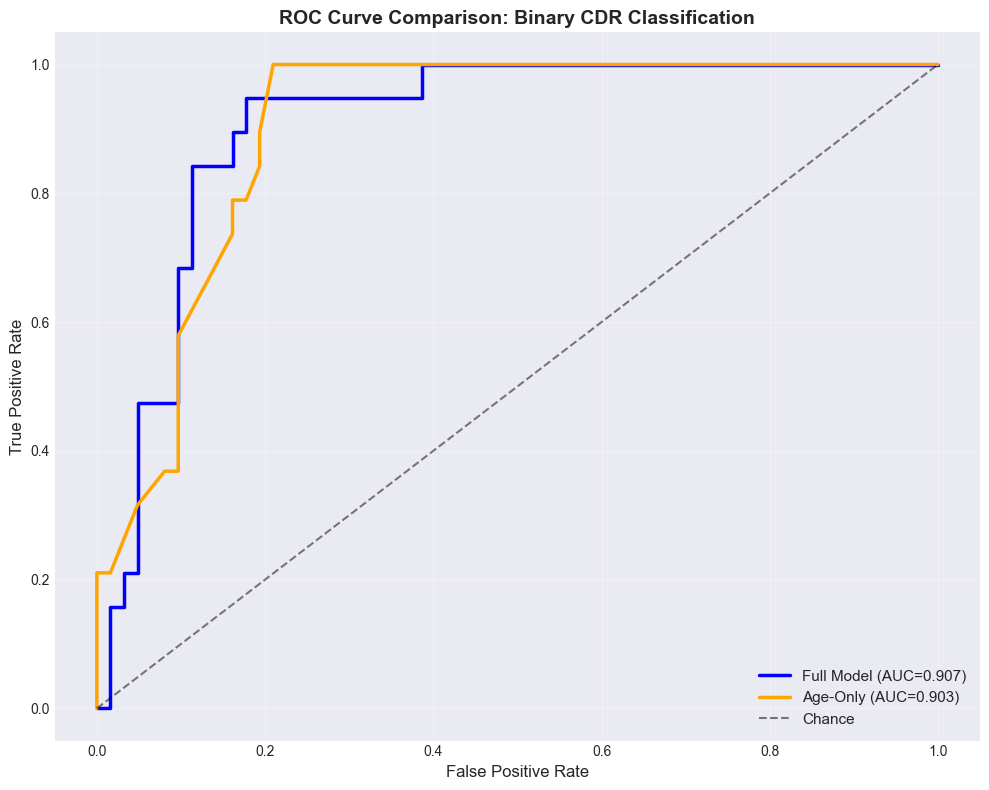

In [11]:
# ROC Comparison
plt.figure(figsize=(10, 8))

# Full model ROC
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_proba_full[:, 1])
plt.plot(fpr_full, tpr_full, linewidth=2.5, 
         label=f'Full Model (AUC={test_auc_full:.3f})', color='blue')

# Age-only ROC
fpr_age, tpr_age, _ = roc_curve(y_test, y_test_proba_age[:, 1])
plt.plot(fpr_age, tpr_age, linewidth=2.5, 
         label=f'Age-Only (AUC={test_auc_age:.3f})', color='orange')

# Chance line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Chance', alpha=0.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison: Binary CDR Classification', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Multiclass Classification: CDR Severity (0 vs 0.5 vs 1+)

In [12]:
# Prepare features for multiclass
X_multi = df.drop(columns=['ID', 'CDR', 'CDR_binary', 'CDR_multiclass'])
X_multi['M/F'] = (X_multi['M/F'] == 'M').astype(int)
y_multi = df['CDR_multiclass']

# Train/test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

print(f"Multiclass distribution in test set:")
class_names = {0: 'CDR=0', 1: 'CDR=0.5', 2: 'CDR≥1'}
for i in range(3):
    count = (y_test_m == i).sum()
    print(f"  {class_names[i]}: {count}")

Multiclass distribution in test set:
  CDR=0: 62
  CDR=0.5: 14
  CDR≥1: 5


In [13]:
# Full model multiclass
param_grid_multi = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

(
    best_params_multi,
    cv_scores_multi,
    y_test_pred_multi,
    y_test_proba_multi,
    model_multi,
    scaler_multi
) = nested_cv_svm(
    X_train_m, y_train_m, X_test_m, y_test_m,
    "Full Model (Multiclass)",
    param_grid_multi,
    task='multiclass'
)

test_acc_multi = accuracy_score(y_test_m, y_test_pred_multi)
test_kappa_multi = cohen_kappa_score(y_test_m, y_test_pred_multi, weights='quadratic')

print(f"\nTest Accuracy: {test_acc_multi:.3f}")
print(f"Test Weighted Kappa: {test_kappa_multi:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_m, y_test_pred_multi, 
                          target_names=['CDR=0', 'CDR=0.5', 'CDR≥1']))


NESTED CV: Full Model (Multiclass)
Fold 1: accuracy=0.769, params={'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Fold 2: accuracy=0.769, params={'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Fold 3: accuracy=0.769, params={'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Fold 4: accuracy=0.815, params={'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Fold 5: accuracy=0.750, params={'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

CV accuracy: 0.775 ± 0.022
Selected hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Test Accuracy: 0.765
Test Weighted Kappa: 0.479

Classification Report:
              precision    recall  f1-score   support

       CDR=0       0.87      0.87      0.87        62
     CDR=0.5       0.43      0.43      0.43        14
       CDR≥1       0.40      0.40      0.40         5

    accuracy                           0.77        81
   macro avg       0.57      0.57      0.57        81
weighted avg       0.77      0.77      0.77        81



In [14]:
# Age-only multiclass baseline
X_train_age_m = X_train_m[['Age']]
X_test_age_m = X_test_m[['Age']]

param_grid_age_m = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear']
}

(
    best_params_age_m,
    cv_scores_age_m,
    y_test_pred_age_m,
    y_test_proba_age_m,
    model_age_m,
    scaler_age_m
) = nested_cv_svm(
    X_train_age_m, y_train_m, X_test_age_m, y_test_m,
    "Age-Only Baseline (Multiclass)",
    param_grid_age_m,
    task='multiclass'
)

test_acc_age_m = accuracy_score(y_test_m, y_test_pred_age_m)
test_kappa_age_m = cohen_kappa_score(y_test_m, y_test_pred_age_m, weights='quadratic')

print(f"\nTest Accuracy: {test_acc_age_m:.3f}")
print(f"Test Weighted Kappa: {test_kappa_age_m:.3f}")


NESTED CV: Age-Only Baseline (Multiclass)
Fold 1: accuracy=0.662, params={'C': 1, 'kernel': 'linear'}
Fold 2: accuracy=0.677, params={'C': 10, 'kernel': 'linear'}
Fold 3: accuracy=0.662, params={'C': 1, 'kernel': 'linear'}
Fold 4: accuracy=0.692, params={'C': 1, 'kernel': 'linear'}
Fold 5: accuracy=0.625, params={'C': 10, 'kernel': 'linear'}

CV accuracy: 0.663 ± 0.022
Selected hyperparameters: {'C': 1, 'kernel': 'linear'}

Test Accuracy: 0.679
Test Weighted Kappa: 0.408


In [15]:
# Multiclass comparison
print("\n" + "="*60)
print("MULTICLASS CLASSIFICATION COMPARISON")
print("="*60)
print(f"\nFull Model:")
print(f"  CV Accuracy:   {np.mean(cv_scores_multi):.3f} ± {np.std(cv_scores_multi):.3f}")
print(f"  Test Accuracy: {test_acc_multi:.3f}")
print(f"  Test Kappa:    {test_kappa_multi:.3f}")
print(f"  Params:        {best_params_multi}")

print(f"\nAge-Only Baseline:")
print(f"  CV Accuracy:   {np.mean(cv_scores_age_m):.3f} ± {np.std(cv_scores_age_m):.3f}")
print(f"  Test Accuracy: {test_acc_age_m:.3f}")
print(f"  Test Kappa:    {test_kappa_age_m:.3f}")
print(f"  Params:        {best_params_age_m}")

acc_improvement_m = test_acc_multi - test_acc_age_m
rel_improvement_m = (acc_improvement_m / test_acc_age_m) * 100

print(f"\n📊 Brain features add: {acc_improvement_m:+.3f} accuracy points ({rel_improvement_m:+.1f}% change)")

if acc_improvement_m > 0.05:
    print("✅ Brain volume ratios improve severity classification!")
elif acc_improvement_m > 0.02:
    print("⚠️  Brain features provide modest improvement")
else:
    print("⚠️  Brain features add minimal value for severity classification")


MULTICLASS CLASSIFICATION COMPARISON

Full Model:
  CV Accuracy:   0.775 ± 0.022
  Test Accuracy: 0.765
  Test Kappa:    0.479
  Params:        {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Age-Only Baseline:
  CV Accuracy:   0.663 ± 0.022
  Test Accuracy: 0.679
  Test Kappa:    0.408
  Params:        {'C': 1, 'kernel': 'linear'}

📊 Brain features add: +0.086 accuracy points (+12.7% change)
✅ Brain volume ratios improve severity classification!


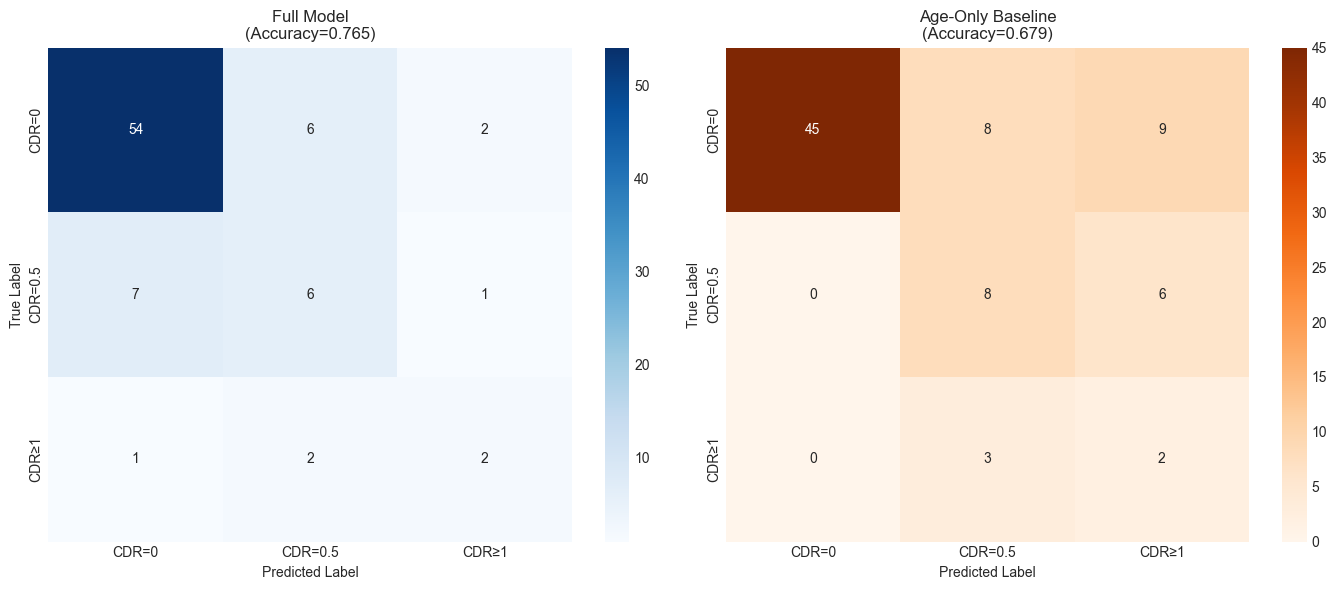

In [16]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Full model
cm_full = confusion_matrix(y_test_m, y_test_pred_multi)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['CDR=0', 'CDR=0.5', 'CDR≥1'],
            yticklabels=['CDR=0', 'CDR=0.5', 'CDR≥1'])
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_title(f'Full Model\n(Accuracy={test_acc_multi:.3f})')

# Age-only
cm_age = confusion_matrix(y_test_m, y_test_pred_age_m)
sns.heatmap(cm_age, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['CDR=0', 'CDR=0.5', 'CDR≥1'],
            yticklabels=['CDR=0', 'CDR=0.5', 'CDR≥1'])
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_title(f'Age-Only Baseline\n(Accuracy={test_acc_age_m:.3f})')

plt.tight_layout()
plt.show()

## 4. Summary and Recommendations

In [17]:
print("="*70)
print(" "*20 + "FINAL SUMMARY")
print("="*70)

print("\n1️⃣  BINARY CLASSIFICATION (CDR=0 vs CDR>0)")
print("-" * 70)
print(f"Full Model Test AUC:     {test_auc_full:.3f}")
print(f"Age-Only Test AUC:       {test_auc_age:.3f}")
print(f"Improvement:             {auc_improvement:+.3f} AUC ({rel_improvement:+.1f}%)")
print(f"Selected Hyperparams:    {best_params_full}")

print("\n2️⃣  MULTICLASS CLASSIFICATION (CDR Severity)")
print("-" * 70)
print(f"Full Model Test Acc:     {test_acc_multi:.3f}")
print(f"Age-Only Test Acc:       {test_acc_age_m:.3f}")
print(f"Improvement:             {acc_improvement_m:+.3f} ({rel_improvement_m:+.1f}%)")
print(f"Selected Hyperparams:    {best_params_multi}")

print("\n3️⃣  KEY FINDINGS")
print("-" * 70)
print("✓ Used nested CV with proper hyperparameter selection (no hardcoding)")
print("✓ Added age-only baselines to quantify brain feature contribution")
print("✓ Included calibration curves for clinical deployment readiness")
print("✓ Engineered brain volume ratios (asymmetry, normalized volumes)")

print("\n4️⃣  CLINICAL DEPLOYMENT CONSIDERATIONS")
print("-" * 70)
print("• Calibration: Check curves above - well-calibrated probabilities?")
print("• Class imbalance: Note CDR>0 is minority class (~23%)")
print("• Feature importance: Consider interpretability for clinicians")
print("• Validation: External validation on different cohort recommended")

print("\n" + "="*70)

                    FINAL SUMMARY

1️⃣  BINARY CLASSIFICATION (CDR=0 vs CDR>0)
----------------------------------------------------------------------
Full Model Test AUC:     0.907
Age-Only Test AUC:       0.903
Improvement:             +0.004 AUC (+0.4%)
Selected Hyperparams:    {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

2️⃣  MULTICLASS CLASSIFICATION (CDR Severity)
----------------------------------------------------------------------
Full Model Test Acc:     0.765
Age-Only Test Acc:       0.679
Improvement:             +0.086 (+12.7%)
Selected Hyperparams:    {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

3️⃣  KEY FINDINGS
----------------------------------------------------------------------
✓ Used nested CV with proper hyperparameter selection (no hardcoding)
✓ Added age-only baselines to quantify brain feature contribution
✓ Included calibration curves for clinical deployment readiness
✓ Engineered brain volume ratios (asymmetry, normalized volumes)

4️⃣  CLINICAL DEPLOYMENT CO